# Предсказание вероятности сердечно-сосудистых заболеваний

Нужно построить модель машинного обучения, которая по табличным данным предсказывает вероятность наличия сердечно-сосудистого заболевания (ССЗ) у пациентов, проходящих регулярную диспансеризацию. Ключевая метрика - ROC AUC.

## Получение общей информации

In [1]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.exceptions import FitFailedWarning

In [2]:
# игнорируем ошибки, возникающие при работе GridSearchCV
simplefilter("ignore", category=FitFailedWarning)

In [3]:
# чтение датасета с обучающими данными
heart_diseases = pd.read_csv('risk_heart_failure_train.csv')

In [4]:
def get_info(df):
    display(df.shape)
    display(df.head())
    display(df.info())
    display(df.describe())
    display(df.quantile([0.01, 0.05, 0.95, 0.99]))
    display(df.isna().sum())

In [5]:
get_info(heart_diseases)

(70000, 13)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


None

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0.01,988.99,14466.0,1.0,147.0,48.0,90.0,60.0,1.0,1.0,0.0,0.0,0.0,0.0
0.05,4954.95,15069.0,1.0,152.0,55.0,100.0,70.0,1.0,1.0,0.0,0.0,0.0,0.0
0.95,94937.15,23259.0,2.0,178.0,100.0,160.0,100.0,3.0,3.0,1.0,1.0,1.0,1.0
0.99,98974.05,23489.0,2.0,184.0,117.0,180.0,1000.0,3.0,3.0,1.0,1.0,1.0,1.0


id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

***Описание данных:***
- id - идентификационный номер пациента;
- age - возраст пациента;
- gender - метка половой принадлежности;
- height - рост пациента;
- weight - вес пациента;
- ap_hi - верхнее значение артериального давления;
- ap_lo - нижнее значение артериального давления;
- cholesterol - холестерин;
- gluc - глюкоза;
- smoke - метка, курит пациент или нет;
- alco - метка, выпивает алкоголь пациент или нет;
- active - метка, ведет пациент активный образ жизни;
- cardio - наличие сердечно-сосудистого заболевания.

- датасет `heart_diseases` содержит 70 000 строк и 13 колонок; 
- столбец `weight` имеет тип данных `float64`, остальные колонки - тип `int`; 
- пропущенных значений нет;
- возраст в колонке `age` записан в днях, рост `height` - в сантиметрах, вес `weight` - в килограммах; 
- в столбцах `height`, `weight`, `ap_hi`, `ap_lo` присутствуют аномальные значения;
- признаки `gender`, `cholesterol`, `gluc`, `smoke`, `alco`, `active` являются категориальными;
- `age`, `height`, `weight`, `ap_hi`, `ap_lo` - количественные признаки;
- целевой признак - `cardio`.

In [6]:
# чтение датасета с тестовыми данными
heart_diseases_test = pd.read_csv('risk_heart_failure_test.csv')

In [7]:
get_info(heart_diseases_test)

(30000, 12)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   age          30000 non-null  int64  
 2   gender       30000 non-null  int64  
 3   height       30000 non-null  int64  
 4   weight       30000 non-null  float64
 5   ap_hi        30000 non-null  int64  
 6   ap_lo        30000 non-null  int64  
 7   cholesterol  30000 non-null  int64  
 8   gluc         30000 non-null  int64  
 9   smoke        30000 non-null  int64  
 10  alco         30000 non-null  int64  
 11  active       30000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.7 MB


None

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000
mean,50062.686900,19455.528400,1.353733,164.322267,74.120615,130.271300,95.689000,1.368033,1.222700,0.08860,0.055000,0.805733
std,28906.167148,2477.840922,0.478136,8.213740,14.341540,212.501152,163.852598,0.679166,0.566494,0.28417,0.227984,0.395642
min,5.000000,8865.000000,1.000000,50.000000,10.000000,-130.000000,-90.000000,1.000000,1.000000,0.00000,0.000000,0.000000
25%,24983.250000,17658.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.00000,0.000000,1.000000
50%,49995.500000,19694.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.00000,0.000000,1.000000
75%,75232.250000,21320.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.00000,0.000000,1.000000
max,99997.000000,23705.000000,2.000000,198.000000,183.000000,16020.000000,9100.000000,3.000000,3.000000,1.00000,1.000000,1.000000


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0.01,1060.69,14459.99,1.0,147.0,48.0,90.0,60.0,1.0,1.0,0.0,0.0,0.0
0.05,5104.70,15007.90,1.0,152.0,55.0,100.0,70.0,1.0,1.0,0.0,0.0,0.0
0.95,95144.20,23252.00,2.0,178.0,100.0,160.0,100.0,3.0,3.0,1.0,1.0,1.0
0.99,99036.02,23484.00,2.0,183.0,116.0,180.0,1000.0,3.0,3.0,1.0,1.0,1.0


id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
dtype: int64

## Предобработка и исследовательский анализ данных

In [8]:
# удаление столбца id
heart_diseases = heart_diseases.drop(columns=['id'])
heart_diseases_test = heart_diseases_test.drop(columns=['id'])

In [9]:
# проверка на дубликаты
heart_diseases.duplicated().sum()

24

In [10]:
# удаление явных дубликатов
heart_diseases = heart_diseases.drop_duplicates().reset_index(drop=True)

In [11]:
# перевод возраста в года
heart_diseases['age'] = round(heart_diseases['age'] / 365).astype('int')
heart_diseases_test['age'] = round(heart_diseases_test['age'] / 365).astype('int')

In [12]:
# линейная корреляция признаков
heart_diseases.corr().style.background_gradient()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.022971,-0.081483,0.053672,0.020794,0.017753,0.154392,0.098595,-0.047903,-0.029931,-0.009810,0.237778
gender,-0.022971,1.000000,0.499080,0.155320,0.005996,0.015241,-0.035915,-0.020558,0.338131,0.170950,0.005917,0.008037
height,-0.081483,0.499080,1.000000,0.290983,0.005488,0.006151,-0.050225,-0.018592,0.188003,0.094425,-0.006569,-0.010871
weight,0.053672,0.155320,0.290983,1.000000,0.030693,0.043695,0.141679,0.106790,0.067725,0.067071,-0.016863,0.181599
ap_hi,0.020794,0.005996,0.005488,0.030693,1.000000,0.016084,0.023768,0.011833,-0.000928,0.001403,-0.000031,0.054475
ap_lo,0.017753,0.015241,0.006151,0.043695,0.016084,1.000000,0.024004,0.010794,0.005177,0.010594,0.004784,0.065717
cholesterol,0.154392,-0.035915,-0.050225,0.141679,0.023768,0.024004,1.000000,0.451539,0.010298,0.035718,0.009927,0.221119
gluc,0.098595,-0.020558,-0.018592,0.106790,0.011833,0.010794,0.451539,1.000000,-0.004799,0.011214,-0.006761,0.089268
smoke,-0.047903,0.338131,0.188003,0.067725,-0.000928,0.005177,0.010298,-0.004799,1.000000,0.340077,0.025870,-0.015533
alco,-0.029931,0.170950,0.094425,0.067071,0.001403,0.010594,0.035718,0.011214,0.340077,1.000000,0.025486,-0.007366


*Вывод:* явной линейной зависимости между признаками и целевым признаком не выявлено. При этом признаки `cholesterol` и `gluc` коррелируют между собой, а также признаки `gender` и `age`.

Построю гистограммы для количественных признаков:

In [13]:
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_theme(style="whitegrid")

Text(0.5, 1.0, 'Histogram of age')

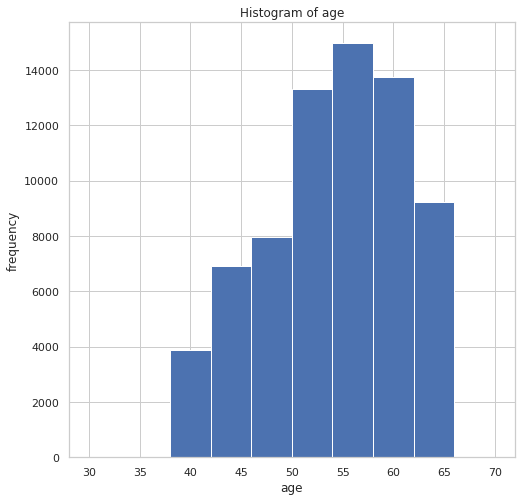

In [14]:
heart_diseases['age'].hist(range=(30, 70))
plt.xlabel('age')
plt.ylabel('frequency')
plt.title('Histogram of age')

*Вывод:* распределение значений возраста не является нормальным, большей половине исследуемых от 50 до 60 лет.

Text(0.5, 1.0, 'Histogram of height')

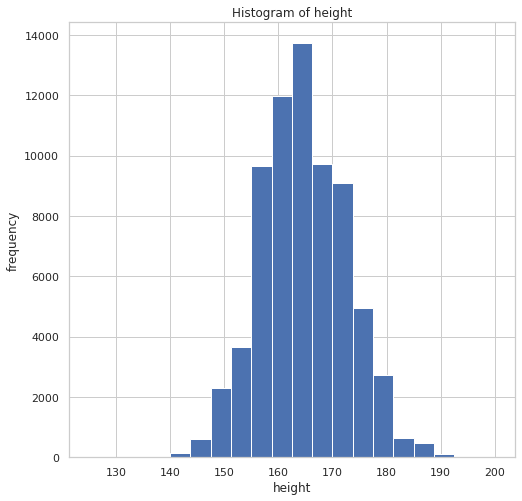

In [15]:
heart_diseases['height'].hist(bins=20, range=(125, 200))
plt.xlabel('height')
plt.ylabel('frequency')
plt.title('Histogram of height')

*Вывод:* показатели роста стремятся к нормальному распределению, большая часть людей ростом от 155 до 175 см.

Text(0.5, 1.0, 'Histogram of weight')

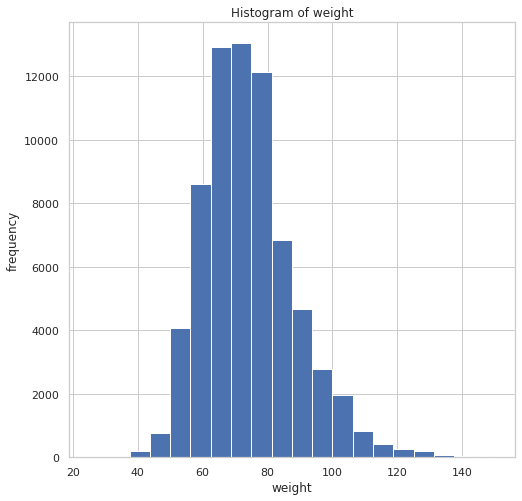

In [16]:
heart_diseases['weight'].hist(bins= 20, range=(25, 150))
plt.xlabel('weight')
plt.ylabel('frequency')
plt.title('Histogram of weight')

*Вывод:* распределение веса слабо стремится к нормальному, наблюдается несколько пиков и скошенность данных вправо.

Text(0.5, 1.0, 'Histogram of ap_hi')

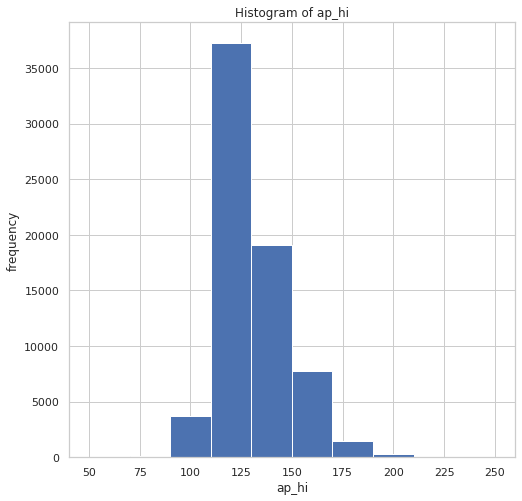

In [17]:
heart_diseases['ap_hi'].hist(range=(50, 250))
plt.xlabel('ap_hi')
plt.ylabel('frequency')
plt.title('Histogram of ap_hi')

*Вывод:* значения верхнего артериального давления не имеют нормального распределения, наблюдается один пик с показателем давления 120-130 мм.рт.ст., что говорит о том, что у большей части людей верхнее давление в норме.

Text(0.5, 1.0, 'Histogram of ap_lo')

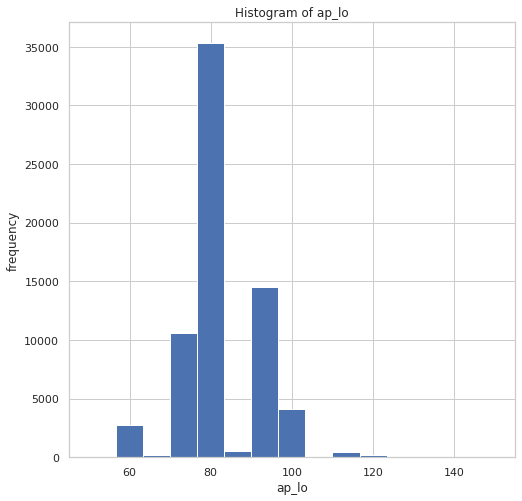

In [18]:
heart_diseases['ap_lo'].hist(bins=15, range=(50, 150))
plt.xlabel('ap_lo')
plt.ylabel('frequency')
plt.title('Histogram of ap_lo')

*Вывод:* значения нижнего артериального давления не распределено нормально. Есть один пик на 80 мм.рт.ст., что говорит о том, что у половины выборки нижнее давление в норме.

In [19]:
"""Функция для преобразования максимумов в показаниях давления"""

def calc_ap(value):
    if value >= 6000:
        return value // 100
    elif value > 600:
        return value // 10
    return abs(value)

In [20]:
heart_diseases['ap_hi'] = heart_diseases['ap_hi'].apply(calc_ap)
heart_diseases['ap_lo'] = heart_diseases['ap_lo'].apply(calc_ap)

# тестовый датафрейм
heart_diseases_test['ap_hi'] = heart_diseases_test['ap_hi'].apply(calc_ap)
heart_diseases_test['ap_lo'] = heart_diseases_test['ap_lo'].apply(calc_ap)

In [21]:
numeric_columns = ['height', 'weight', 'ap_hi', 'ap_lo']

In [22]:
"""Функция для замены аномальных значений 1-м и 99-м процентилями"""

def replace_ejection(df):
    df_copy = df.copy()
    for name in numeric_columns:
        q_1 = int(df_copy[name].quantile(0.01))
        q_99 = int(df_copy[name].quantile(0.99))
        df_copy.loc[(df_copy[name] < q_1), name] = q_1
        df_copy.loc[(df_copy[name] > q_99), name] = q_99
    return df_copy

In [23]:
heart_diseases = replace_ejection(heart_diseases)

# тестовый датафрейм
heart_diseases_test = replace_ejection(heart_diseases_test)

In [24]:
display(heart_diseases.info())
display(heart_diseases_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69976 non-null  int64  
 1   gender       69976 non-null  int64  
 2   height       69976 non-null  int64  
 3   weight       69976 non-null  float64
 4   ap_hi        69976 non-null  int64  
 5   ap_lo        69976 non-null  int64  
 6   cholesterol  69976 non-null  int64  
 7   gluc         69976 non-null  int64  
 8   smoke        69976 non-null  int64  
 9   alco         69976 non-null  int64  
 10  active       69976 non-null  int64  
 11  cardio       69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          30000 non-null  int64  
 1   gender       30000 non-null  int64  
 2   height       30000 non-null  int64  
 3   weight       30000 non-null  float64
 4   ap_hi        30000 non-null  int64  
 5   ap_lo        30000 non-null  int64  
 6   cholesterol  30000 non-null  int64  
 7   gluc         30000 non-null  int64  
 8   smoke        30000 non-null  int64  
 9   alco         30000 non-null  int64  
 10  active       30000 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 2.5 MB


None

Исследую, как меняется наличие сердечно-сосудистых заболеваний в зависимости от возраста:

In [25]:
heart_diseases_age = heart_diseases[['age', 'cardio']].copy()
heart_diseases_age.head()

,age,cardio
0,50,0
1,55,1
2,52,1
3,48,1
4,48,0


In [26]:
pd.qcut(heart_diseases_age['age'], q=5, precision=0).head()

0    (47.0, 52.0]
1    (52.0, 56.0]
2    (47.0, 52.0]
3    (47.0, 52.0]
4    (47.0, 52.0]
Name: age, dtype: category
Categories (5, interval[float64]): [(29.0, 47.0] < (47.0, 52.0] < (52.0, 56.0] < (56.0, 60.0] < (60.0, 65.0]]

In [27]:
age_labels = ['30-47', '48-52', '53-56', '57-60', '61-65']
heart_diseases_age['age_groups'] = pd.qcut(heart_diseases_age['age'], labels=age_labels, q=5)

<AxesSubplot:xlabel='age_groups'>

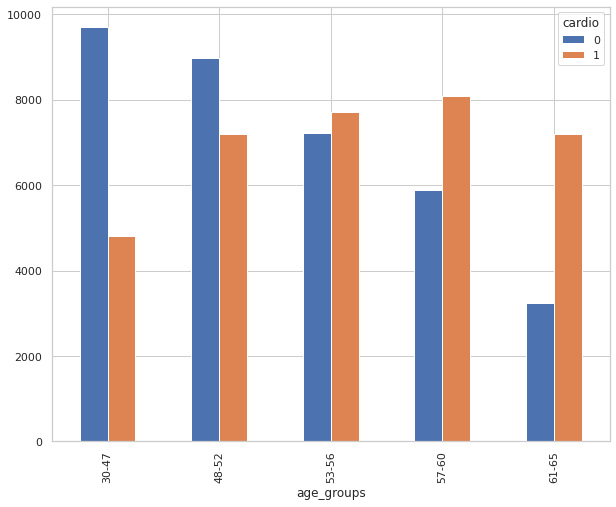

In [28]:
heart_diseases_age.pivot_table(
    index=['age_groups'], columns='cardio', values='age', aggfunc='count'
).plot(kind='bar', grid=True, figsize=(10,8))

*Вывод:* по результатам графика видно, что наличие ССЗ в каждой возрастной группе увеличивается с возрастом.

### Добавление новых признаков

In [29]:
# пульсовое давление 
heart_diseases['pulse_pressure'] = heart_diseases['ap_hi'] - heart_diseases['ap_lo']

heart_diseases_test['pulse_pressure'] = heart_diseases_test['ap_hi'] - heart_diseases_test['ap_lo']

In [30]:
# среднее артериальное давление
heart_diseases['map'] = round(heart_diseases['ap_lo'] + heart_diseases['pulse_pressure'] / 3, 2)

heart_diseases_test['map'] = round(heart_diseases_test['ap_lo'] + heart_diseases_test['pulse_pressure'] / 3, 2)

In [31]:
# индекс массы тела
heart_diseases['body_mass_index'] = round(
    heart_diseases['weight'] / ((heart_diseases['height'] / 100) ** 2), 2
)

heart_diseases_test['body_mass_index'] = round(
    heart_diseases_test['weight'] / ((heart_diseases_test['height'] / 100) ** 2), 2
)

In [32]:
# логарифм значения верхнего давления
heart_diseases['ap_hi_log'] = round(np.log(heart_diseases['ap_hi']), 2)
heart_diseases_test['ap_hi_log'] = round(np.log(heart_diseases_test['ap_hi']), 2)

In [33]:
# логарифм значения нижнего давления
heart_diseases['ap_lo_log'] = round(np.log(heart_diseases['ap_lo']), 2)
heart_diseases_test['ap_lo_log'] = round(np.log(heart_diseases_test['ap_lo']), 2)

In [34]:
display(heart_diseases.head())
display(heart_diseases_test.head())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,pulse_pressure,map,body_mass_index,ap_hi_log,ap_lo_log
0,50,2,168,62.0,110,80,1,1,0,0,1,0,30,90.00,21.97,4.70,4.38
1,55,1,156,85.0,140,90,3,1,0,0,1,1,50,106.67,34.93,4.94,4.50
2,52,1,165,64.0,130,70,3,1,0,0,0,1,60,90.00,23.51,4.87,4.25
3,48,2,169,82.0,150,100,1,1,0,0,1,1,50,116.67,28.71,5.01,4.61
4,48,1,156,56.0,100,60,1,1,0,0,0,0,40,73.33,23.01,4.61,4.09


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,pulse_pressure,map,body_mass_index,ap_hi_log,ap_lo_log
0,52,1,154,85.0,130,80,1,1,0,0,1,50,96.67,35.84,4.87,4.38
1,52,2,170,69.0,130,90,1,1,0,0,1,40,103.33,23.88,4.87,4.50
2,56,1,160,70.0,120,75,1,1,0,0,0,45,90.00,27.34,4.79,4.32
3,50,2,183,94.0,130,90,1,1,0,0,1,40,103.33,28.07,4.87,4.50
4,44,2,170,76.0,120,80,1,1,0,0,1,40,93.33,26.30,4.79,4.38


Посчитаю вероятности риска сердечно-сосудистого заболевания для пациентов с различными показателями.

- *вероятность риска ССЗ у пациентов старше 53 лет:*

In [35]:
hd_age_53 = heart_diseases.query('age >= 53')
hd_age_53_cardio = hd_age_53.query('cardio == 1')
print(f'{round(hd_age_53_cardio.shape[0] * 100 / hd_age_53.shape[0], 2)} %')

58.45 %


- *вероятность риска ССЗ у пациентов с индексом массы тела более 30:*

In [36]:
hd_bmi_30 = heart_diseases.query('body_mass_index >= 30')
hd_bmi_30_cardio = hd_bmi_30.query('cardio == 1')
print(f'{round(hd_bmi_30_cardio.shape[0] * 100 / hd_bmi_30.shape[0], 2)} %')

63.08 %


- *вероятность риска ССЗ у пациентов с повышенным содержанием холестерина или глюкозы:*

In [37]:
hd_harmful_habits = heart_diseases.query('cholesterol in (1, 2, 3) or gluc == 1')
hd_harmful_habits_cadrio = hd_harmful_habits.query('cardio == 1')
print(f'{round(hd_harmful_habits_cadrio.shape[0]*100/hd_harmful_habits.shape[0], 2)} %')

49.98 %


- *вероятность риска ССЗ у пациентов с вредными привычками:*

In [38]:
hd_harmful_habits = heart_diseases.query('alco == 1 or smoke == 1')
hd_harmful_habits_cadrio = hd_harmful_habits.query('cardio == 1')
print(f'{round(hd_harmful_habits_cadrio.shape[0]*100/hd_harmful_habits.shape[0], 2)} %')

48.62 %


- *вероятность риска ССЗ у пациентов, которые не ведут активный образ жизни:*

In [39]:
hd_not_active = heart_diseases.query('active == 0')
hd_not_active_cadrio = hd_not_active.query('cardio == 1')
print(f'{round(hd_not_active_cadrio.shape[0]*100/hd_not_active.shape[0], 2)} %')

53.59 %


## Подготовка признаков для обучения модели

In [40]:
features_train = heart_diseases.drop(['cardio'], axis=1)

In [41]:
target_train = heart_diseases['cardio']

In [42]:
# размеры полученных выборок
print(features_train.shape)
print(target_train.shape)

(69976, 16)
(69976,)


In [43]:
# проверка на баланс классов
target_train[target_train == 1].count() / target_train[target_train == 0].count()

0.9990858187635698

*Вывод*: выборка сбалансирована.

In [44]:
features_test = heart_diseases_test

### Масштабирование признаков

In [45]:
numeric = [
    'age', 'height', 'weight', 'body_mass_index', 
    'pulse_pressure', 'map',
    'ap_hi_log', 'ap_lo_log', 'ap_hi', 'ap_lo',
]

In [46]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [47]:
display(features_train.head())
display(features_test.head())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,pulse_pressure,map,body_mass_index,ap_hi_log,ap_lo_log
0,0.571429,2,0.567568,0.202899,0.222222,0.4,1,1,0,0,1,0.357143,0.315806,0.182880,0.289855,0.475410
1,0.714286,1,0.243243,0.536232,0.555556,0.6,3,1,0,0,1,0.500000,0.579030,0.512065,0.637681,0.672131
2,0.628571,1,0.486486,0.231884,0.444444,0.2,3,1,0,0,0,0.571429,0.315806,0.221996,0.536232,0.262295
3,0.514286,2,0.594595,0.492754,0.666667,0.8,1,1,0,0,1,0.500000,0.736934,0.354077,0.739130,0.852459
4,0.514286,1,0.243243,0.115942,0.111111,0.0,1,1,0,0,0,0.428571,0.052582,0.209296,0.159420,0.000000


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,pulse_pressure,map,body_mass_index,ap_hi_log,ap_lo_log
0,0.628571,1,0.189189,0.536232,0.444444,0.4,1,1,0,0,1,0.500000,0.421127,0.535179,0.536232,0.475410
1,0.628571,2,0.621622,0.304348,0.444444,0.6,1,1,0,0,1,0.428571,0.526291,0.231394,0.536232,0.672131
2,0.742857,1,0.351351,0.318841,0.333333,0.3,1,1,0,0,0,0.464286,0.315806,0.319279,0.420290,0.377049
3,0.571429,2,0.972973,0.666667,0.444444,0.6,1,1,0,0,1,0.428571,0.526291,0.337821,0.536232,0.672131
4,0.400000,2,0.621622,0.405797,0.333333,0.4,1,1,0,0,1,0.428571,0.368388,0.292863,0.420290,0.475410


### Техника прямого кодирования

In [48]:
categorical_columns = ['cholesterol', 'gluc']

In [49]:
features_train_encoder = features_train.loc[:]

encoder = OneHotEncoder(handle_unknown='error', drop='first')
encoder.fit(features_train_encoder[categorical_columns])
features_train_encoded = encoder.transform(features_train_encoder[categorical_columns]).toarray()
features_train_encoded

array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [50]:
features_train_df = pd.DataFrame(
    features_train_encoded, 
    columns=encoder.get_feature_names(categorical_columns),
    index=features_train.index
)
features_train_df.head()

,cholesterol_2,cholesterol_3,gluc_2,gluc_3
0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [51]:
features_train_drop = features_train.drop(categorical_columns, axis=1)
features_train_drop.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,pulse_pressure,map,body_mass_index,ap_hi_log,ap_lo_log
0,0.571429,2,0.567568,0.202899,0.222222,0.4,0,0,1,0.357143,0.315806,0.182880,0.289855,0.475410
1,0.714286,1,0.243243,0.536232,0.555556,0.6,0,0,1,0.500000,0.579030,0.512065,0.637681,0.672131
2,0.628571,1,0.486486,0.231884,0.444444,0.2,0,0,0,0.571429,0.315806,0.221996,0.536232,0.262295
3,0.514286,2,0.594595,0.492754,0.666667,0.8,0,0,1,0.500000,0.736934,0.354077,0.739130,0.852459
4,0.514286,1,0.243243,0.115942,0.111111,0.0,0,0,0,0.428571,0.052582,0.209296,0.159420,0.000000


In [52]:
features_train_ohe = pd.concat((features_train_drop, features_train_df), axis=1)
features_train_ohe.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,pulse_pressure,map,body_mass_index,ap_hi_log,ap_lo_log,cholesterol_2,cholesterol_3,gluc_2,gluc_3
0,0.571429,2,0.567568,0.202899,0.222222,0.4,0,0,1,0.357143,0.315806,0.182880,0.289855,0.475410,0.0,0.0,0.0,0.0
1,0.714286,1,0.243243,0.536232,0.555556,0.6,0,0,1,0.500000,0.579030,0.512065,0.637681,0.672131,0.0,1.0,0.0,0.0
2,0.628571,1,0.486486,0.231884,0.444444,0.2,0,0,0,0.571429,0.315806,0.221996,0.536232,0.262295,0.0,1.0,0.0,0.0
3,0.514286,2,0.594595,0.492754,0.666667,0.8,0,0,1,0.500000,0.736934,0.354077,0.739130,0.852459,0.0,0.0,0.0,0.0
4,0.514286,1,0.243243,0.115942,0.111111,0.0,0,0,0,0.428571,0.052582,0.209296,0.159420,0.000000,0.0,0.0,0.0,0.0


- тестовый датасет:

In [53]:
features_test_encoder = features_test.loc[:]
features_test_encoded = encoder.transform(features_test_encoder[categorical_columns]).toarray()
features_test_encoded

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [54]:
features_test_df = pd.DataFrame(
    features_test_encoded, 
    columns=encoder.get_feature_names(categorical_columns),
    index=features_test.index
)
features_test_df.head()

,cholesterol_2,cholesterol_3,gluc_2,gluc_3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [55]:
features_test_drop = features_test.drop(categorical_columns, axis=1)
features_test_drop.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,pulse_pressure,map,body_mass_index,ap_hi_log,ap_lo_log
0,0.628571,1,0.189189,0.536232,0.444444,0.4,0,0,1,0.500000,0.421127,0.535179,0.536232,0.475410
1,0.628571,2,0.621622,0.304348,0.444444,0.6,0,0,1,0.428571,0.526291,0.231394,0.536232,0.672131
2,0.742857,1,0.351351,0.318841,0.333333,0.3,0,0,0,0.464286,0.315806,0.319279,0.420290,0.377049
3,0.571429,2,0.972973,0.666667,0.444444,0.6,0,0,1,0.428571,0.526291,0.337821,0.536232,0.672131
4,0.400000,2,0.621622,0.405797,0.333333,0.4,0,0,1,0.428571,0.368388,0.292863,0.420290,0.475410


In [56]:
features_test_ohe = pd.concat((features_test_drop, features_test_df), axis=1)
features_test_ohe.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,pulse_pressure,map,body_mass_index,ap_hi_log,ap_lo_log,cholesterol_2,cholesterol_3,gluc_2,gluc_3
0,0.628571,1,0.189189,0.536232,0.444444,0.4,0,0,1,0.500000,0.421127,0.535179,0.536232,0.475410,0.0,0.0,0.0,0.0
1,0.628571,2,0.621622,0.304348,0.444444,0.6,0,0,1,0.428571,0.526291,0.231394,0.536232,0.672131,0.0,0.0,0.0,0.0
2,0.742857,1,0.351351,0.318841,0.333333,0.3,0,0,0,0.464286,0.315806,0.319279,0.420290,0.377049,0.0,0.0,0.0,0.0
3,0.571429,2,0.972973,0.666667,0.444444,0.6,0,0,1,0.428571,0.526291,0.337821,0.536232,0.672131,0.0,0.0,0.0,0.0
4,0.400000,2,0.621622,0.405797,0.333333,0.4,0,0,1,0.428571,0.368388,0.292863,0.420290,0.475410,0.0,0.0,0.0,0.0


In [57]:
display(features_train_ohe.head())
display(features_test_ohe.head())

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,pulse_pressure,map,body_mass_index,ap_hi_log,ap_lo_log,cholesterol_2,cholesterol_3,gluc_2,gluc_3
0,0.571429,2,0.567568,0.202899,0.222222,0.4,0,0,1,0.357143,0.315806,0.182880,0.289855,0.475410,0.0,0.0,0.0,0.0
1,0.714286,1,0.243243,0.536232,0.555556,0.6,0,0,1,0.500000,0.579030,0.512065,0.637681,0.672131,0.0,1.0,0.0,0.0
2,0.628571,1,0.486486,0.231884,0.444444,0.2,0,0,0,0.571429,0.315806,0.221996,0.536232,0.262295,0.0,1.0,0.0,0.0
3,0.514286,2,0.594595,0.492754,0.666667,0.8,0,0,1,0.500000,0.736934,0.354077,0.739130,0.852459,0.0,0.0,0.0,0.0
4,0.514286,1,0.243243,0.115942,0.111111,0.0,0,0,0,0.428571,0.052582,0.209296,0.159420,0.000000,0.0,0.0,0.0,0.0


,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,pulse_pressure,map,body_mass_index,ap_hi_log,ap_lo_log,cholesterol_2,cholesterol_3,gluc_2,gluc_3
0,0.628571,1,0.189189,0.536232,0.444444,0.4,0,0,1,0.500000,0.421127,0.535179,0.536232,0.475410,0.0,0.0,0.0,0.0
1,0.628571,2,0.621622,0.304348,0.444444,0.6,0,0,1,0.428571,0.526291,0.231394,0.536232,0.672131,0.0,0.0,0.0,0.0
2,0.742857,1,0.351351,0.318841,0.333333,0.3,0,0,0,0.464286,0.315806,0.319279,0.420290,0.377049,0.0,0.0,0.0,0.0
3,0.571429,2,0.972973,0.666667,0.444444,0.6,0,0,1,0.428571,0.526291,0.337821,0.536232,0.672131,0.0,0.0,0.0,0.0
4,0.400000,2,0.621622,0.405797,0.333333,0.4,0,0,1,0.428571,0.368388,0.292863,0.420290,0.475410,0.0,0.0,0.0,0.0


## Features importance

Чтобы посмотреть какие признаки влияют на обучение модели для предсказания ССЗ выведу градацию признаков по важности:

- *модель Random Forest*

In [58]:
model_rf = RandomForestClassifier()
model_rf.fit(features_train, target_train)

RandomForestClassifier()

In [59]:
def print_features_importance(model, column_names):
    feats = {}
    for feature, importance in zip(column_names, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='lightgreen')
    plt.xlabel('Importance', fontsize=25, weight = 'bold')
    plt.ylabel('Features', fontsize=25, weight = 'bold')
    plt.title(f'Feature Importance for {model.__class__.__name__}', fontsize=25, weight = 'bold')
    display(plt.show())

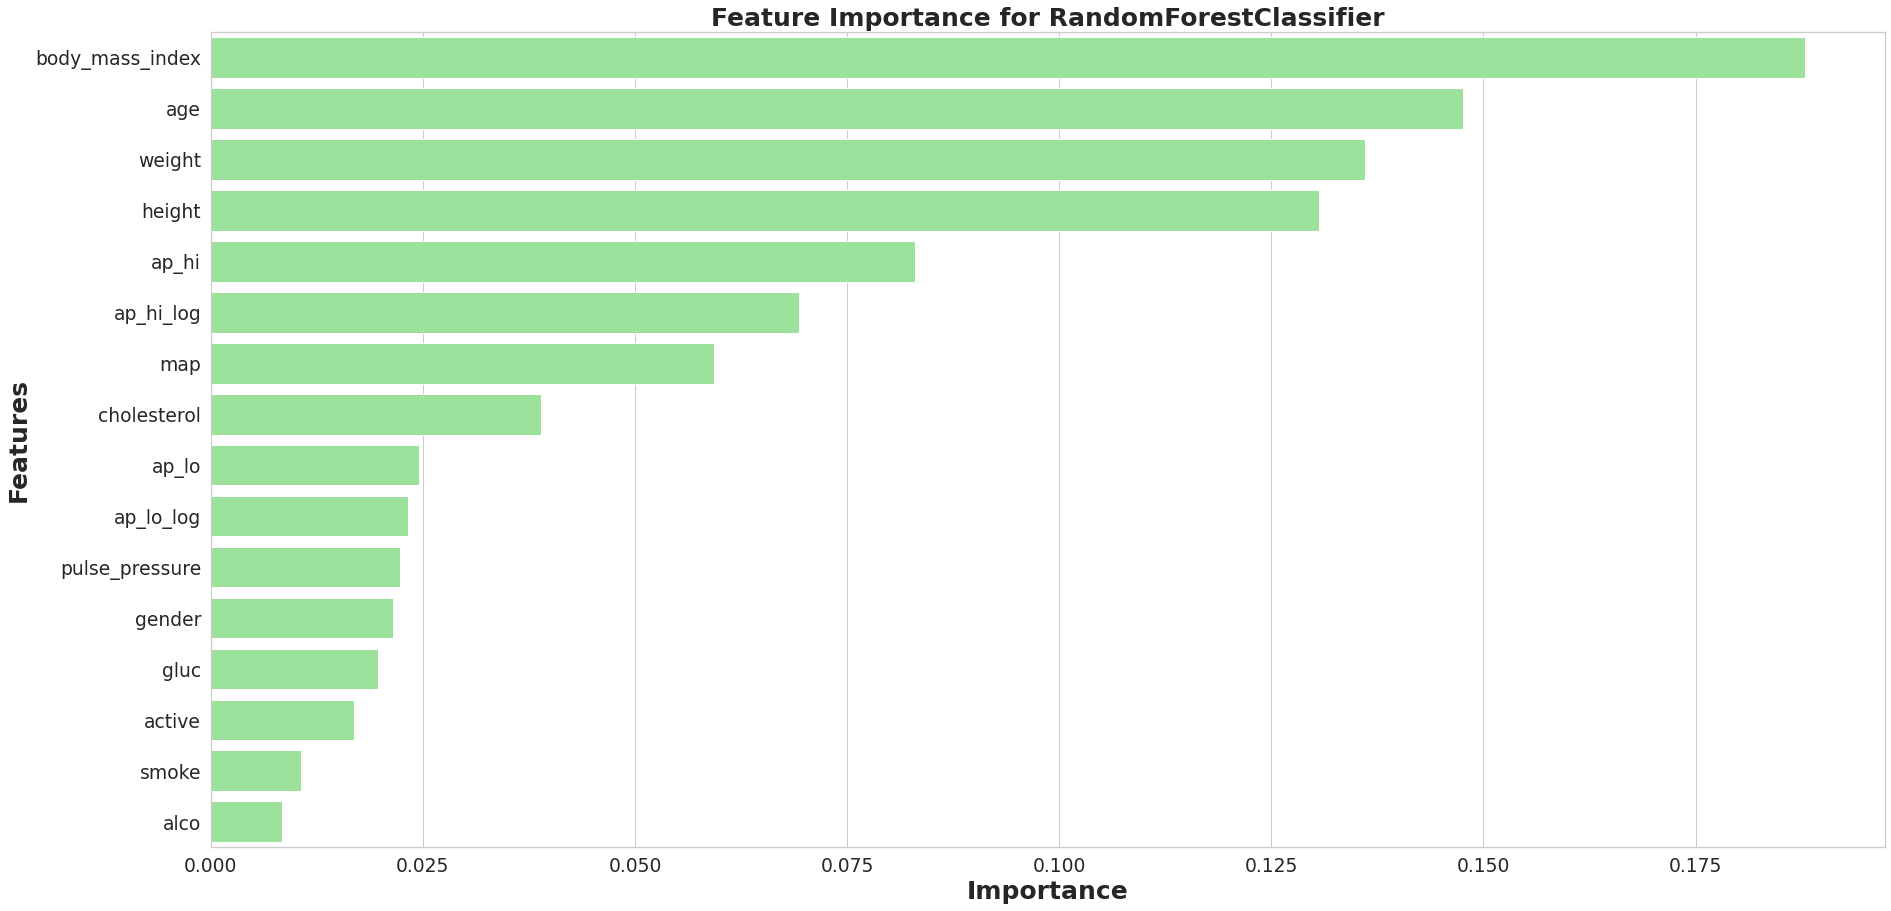

None

In [60]:
print_features_importance(model_rf, features_train.columns)

*Вывод:* на обучение модели случайного леса наибольшее влияние оказывает новый признак индекса массы тела. Признаки наличия вредных привычек (курение и алкоголь) оказывают наименьшее влияние на модель.

- *Gradient Boosting Classifier*

In [61]:
model_gb = GradientBoostingClassifier()
model_gb.fit(features_train, target_train)

GradientBoostingClassifier()

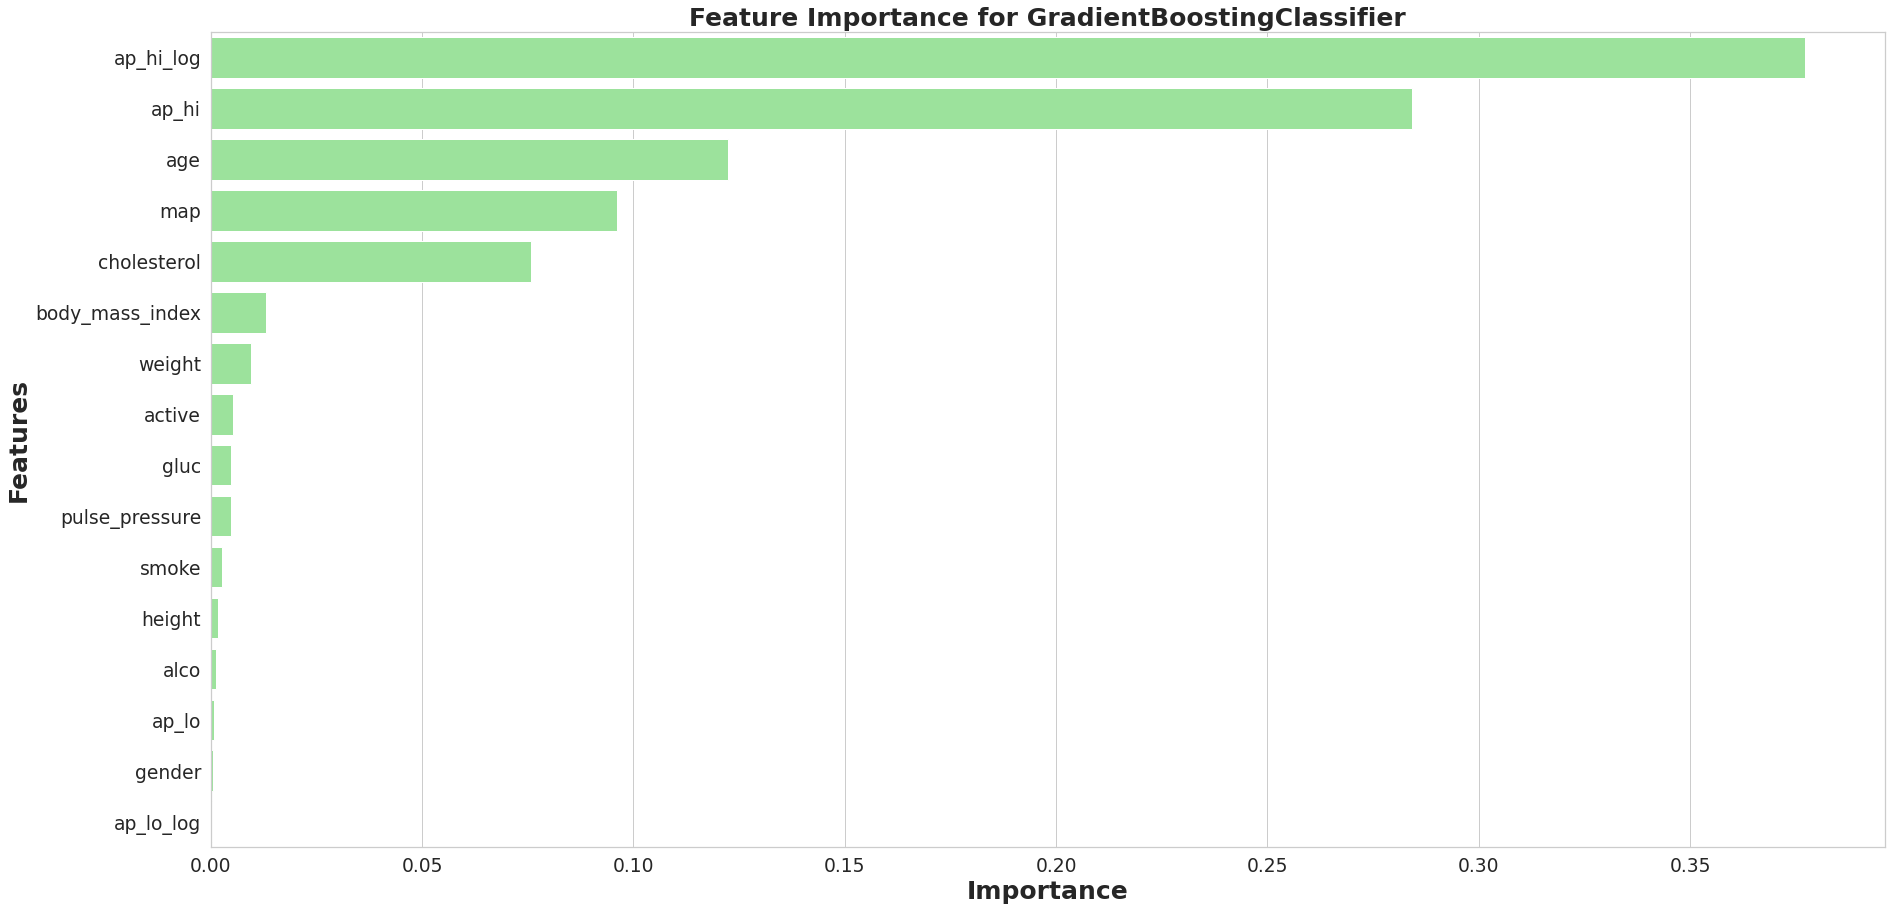

None

In [62]:
print_features_importance(model_gb, features_train.columns)

*Вывод:* для модели градиентного бустинга наиболее важными является значение верхнего артериального давления (как и оригинальный показатель, так и логарифм значения). Но в то же время нижнее артериальное давление, а так же пол пациента, неважны для данной модели.

- AdaBoostClassifier

In [63]:
model_ab = AdaBoostClassifier()
model_ab.fit(features_train, target_train)

AdaBoostClassifier()

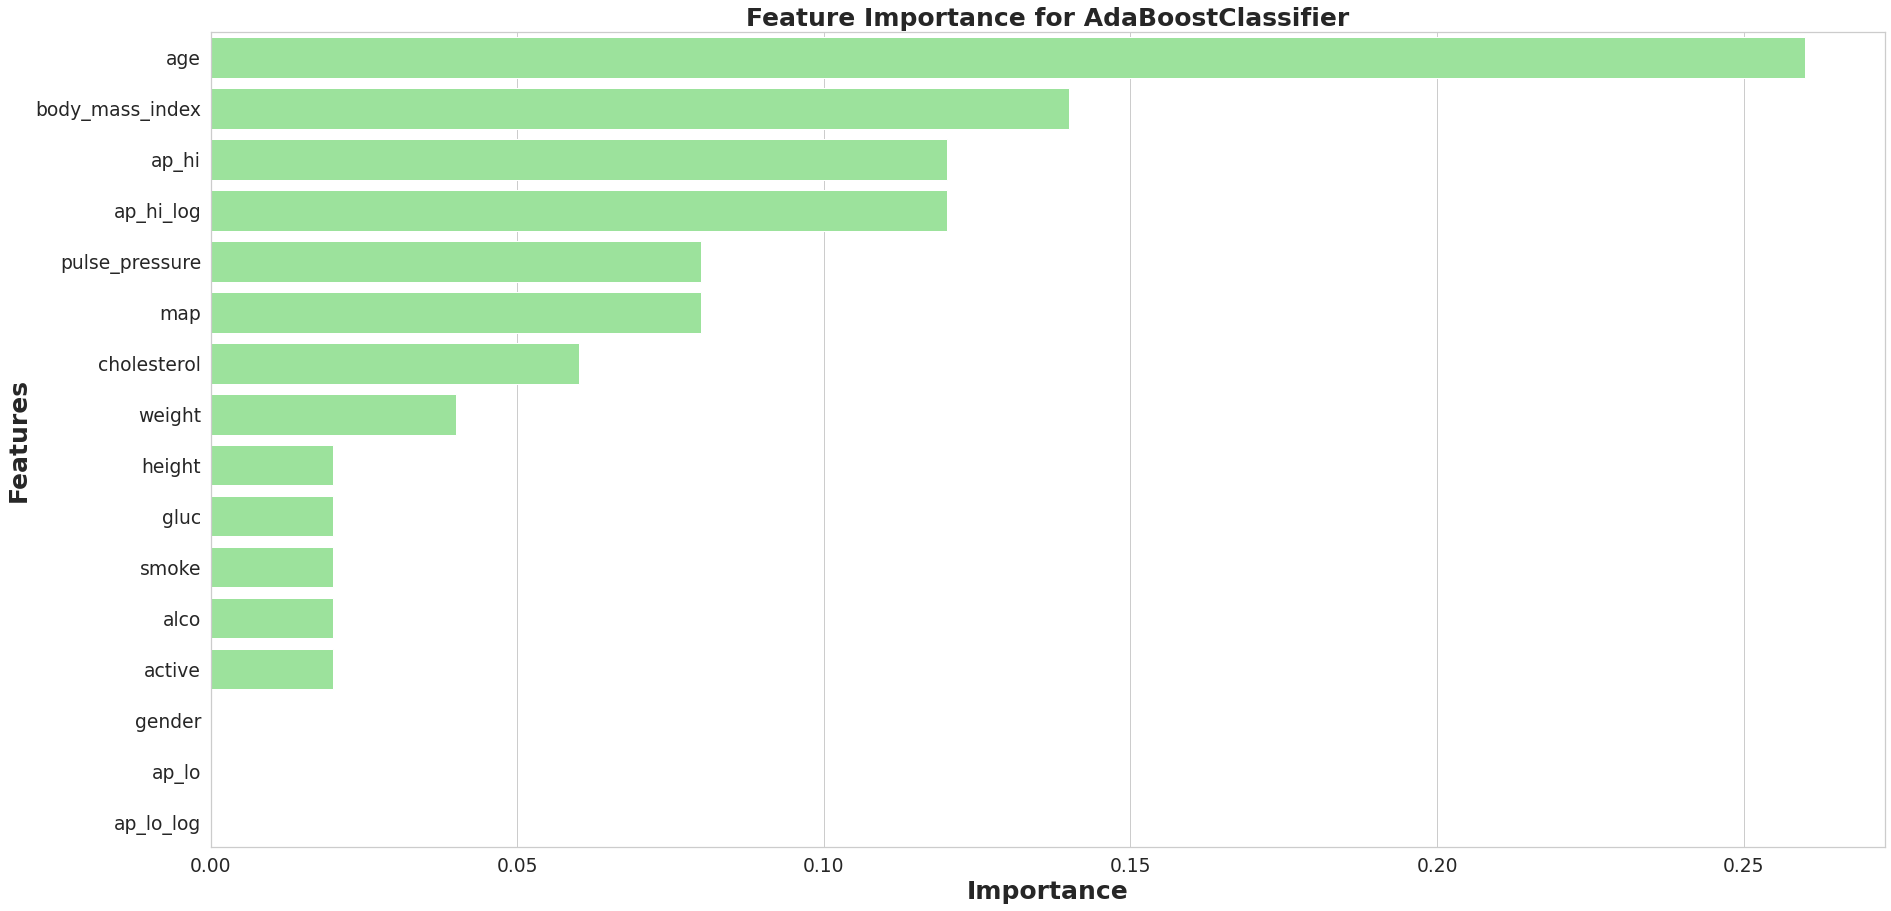

None

In [64]:
print_features_importance(model_ab, features_train.columns)

*Вывод:* для модели AdaBoost признак возраста наиболее важен. Признаки пола, нижнего артериального давления и его логарифма не представляются важными.

## GridSearchCV

- *Logistic Regression*

In [66]:
model_logistic_regression = LogisticRegression()

In [67]:
parametrs = {
    'penalty': ['l1', 'l2'],
    'C': [0.2, 0.4, 0.6, 0.8, 1.0],
    'solver': ['lbfgs', 'liblinear']
}

In [71]:
%%time
grid = GridSearchCV(model_logistic_regression, parametrs, n_jobs=-1, cv=5, scoring='roc_auc')
grid.fit(features_train_ohe, target_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.79174902 0.79141681 0.79144884        nan 0.79274821
 0.79188188 0.79189945        nan 0.79307981 0.79219224 0.79219972
        nan 0.79325118 0.79240487 0.79241291        nan 0.79334348
 0.79257558 0.79257625]
  warnings.warn(


CPU times: user 6min 33s, sys: 54.6 s, total: 7min 28s
Wall time: 7min 46s


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc')

In [72]:
grid.best_params_

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

**Лучшие гиперпараметры: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}**

- *Random Forest*

In [73]:
model_random_forest = RandomForestClassifier()

In [74]:
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (2, 11, 2),
              'min_samples_leaf': range (1, 6),
              'min_samples_split': range (2, 7, 2) }

In [73]:
%%time
grid = GridSearchCV(model_random_forest, parametrs, n_jobs=-1, verbose=1, cv=5, scoring='roc_auc')
grid.fit(features_train, target_train)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
CPU times: user 19min 37s, sys: 4.43 s, total: 19min 42s
Wall time: 19min 42s


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(2, 11, 2),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 7, 2),
                         'n_estimators': range(10, 51, 10)},
             scoring='roc_auc', verbose=1)

In [74]:
grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 50}

**Лучшие гиперпараметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 50}**

- *Gradient Boosting Classifier*

In [75]:
gradient_boosting_model = GradientBoostingClassifier()

In [76]:
parametrs = {
    'n_estimators': [75, 100, 125],
    'subsample': [0.5, 0.75, 1.0],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
    }

In [77]:
%%time
grid = GridSearchCV(gradient_boosting_model, parametrs, n_jobs=-1, verbose=1, cv=5, scoring='roc_auc')
grid.fit(features_train, target_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
CPU times: user 1h 2min 45s, sys: 3.35 s, total: 1h 2min 49s
Wall time: 1h 2min 54s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 125],
                         'subsample': [0.5, 0.75, 1.0]},
             scoring='roc_auc', verbose=1)

In [78]:
grid.best_params_

{'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 0.75}

**Лучшие гиперпараметры: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.75}**

## Обучение моделей

In [65]:
%%time
"""Модель логистической регрессии"""

model_logistic_regression = LogisticRegression(
    C=1.0, 
    penalty='l1', 
    solver='liblinear', 
    random_state=123, 
    n_jobs=-1
)
scores = cross_val_score(
    model_logistic_regression, features_train_ohe, target_train, cv=5, scoring='roc_auc'
)
final_score = sum(scores) / len(scores)
print(
    f'Средняя оценка качества модели: {final_score}',
    f'Качество модели для выборок: {scores}',
    sep='\n'
)

Средняя оценка качества модели: 0.7933563543636631
Качество модели для выборок: [0.78818898 0.79654375 0.79753881 0.79575565 0.78875458]
CPU times: user 1min 1s, sys: 490 ms, total: 1min 1s
Wall time: 1min 1s


***0.79335***

In [147]:
%%time
"""Модель случайного леса"""

model_random_forest = RandomForestClassifier(
    max_depth=10, 
    min_samples_leaf=1, 
    min_samples_split=6, 
    n_estimators=50, 
    random_state=123,
    n_jobs=-1
)
scores = cross_val_score(
    model_random_forest, features_train, target_train, cv=5, scoring='roc_auc'
)
final_score = sum(scores) / len(scores)
print(
    f'Средняя оценка качества модели: {final_score}',
    f'Качество модели для выборок: {scores}',
    sep='\n'
)

Средняя оценка качества модели: 0.801099782288377
Качество модели для выборок: [0.79610785 0.80545568 0.80396337 0.80277117 0.79720085]
CPU times: user 8.67 s, sys: 39.4 ms, total: 8.71 s
Wall time: 8.71 s


***0.80109***

In [149]:
%%time
"""Модель AdaBoostClassifier"""

tree = DecisionTreeClassifier(max_depth=4, random_state=123)
adaboost = AdaBoostClassifier(base_estimator=tree,
                              n_estimators=50, 
                              learning_rate=0.1, 
                              algorithm='SAMME.R', 
                              random_state=123
                         )
scores = cross_val_score(adaboost, features_train, target_train, cv=5, scoring='roc_auc')
final_score = sum(scores) / len(scores)

print(
    f'Средняя оценка качества модели: {final_score}',
    f'Качество модели для выборок: {scores}',
    sep='\n'
)

Средняя оценка качества модели: 0.8020682023911474
Качество модели для выборок: [0.79718887 0.80649707 0.80432374 0.80360902 0.79872231]
CPU times: user 19.9 s, sys: 31.3 ms, total: 19.9 s
Wall time: 19.9 s


***0.80206***

In [151]:
%%time
"""GradientBoostingClassifier"""

gb_model = GradientBoostingClassifier(
    n_estimators=100, 
    subsample=0.75, 
    max_depth=4, 
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=123
)
scores = cross_val_score(gb_model, features_train, target_train, cv=5, scoring='roc_auc')
final_score = sum(scores) / len(scores)
print(
    f'Средняя оценка качества модели: {final_score}',
    f'Качество модели для выборок: {scores}',
    sep='\n'
)

Средняя оценка качества модели: 0.8031248059520806
Качество модели для выборок: [0.7984118  0.80713857 0.80581146 0.8050056  0.7992566 ]
CPU times: user 30.7 s, sys: 18.8 ms, total: 30.7 s
Wall time: 30.7 s


***0.80312***

In [152]:
%%time
"""MLPClassifier"""

model_mlp = MLPClassifier(random_state=123)
scores = cross_val_score(
    model_mlp, features_train, target_train, cv=5, scoring='roc_auc'
)
final_score = sum(scores) / len(scores)
print(
    f'Средняя оценка качества модели: {final_score}',
    f'Качество модели для выборок: {scores}',
    sep='\n'
)

Средняя оценка качества модели: 0.8015803270836896
Качество модели для выборок: [0.79748358 0.80548606 0.8040774  0.80309017 0.79776442]
CPU times: user 26min 30s, sys: 29min 50s, total: 56min 21s
Wall time: 56min 29s


***0.80158***

In [153]:
%%time
"""XGBClassifier()"""

xgb_model = xgboost.XGBClassifier()
scores = cross_val_score(xgb_model, features_train_ohe, target_train, cv=5, scoring='roc_auc')
final_score = sum(scores) / len(scores)
print(
    f'Средняя оценка качества модели: {final_score}',
    f'Качество модели для выборок: {scores}',
    sep='\n'
)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:06:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:06:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:06:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:07:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:07:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Средняя оценка качества модели: 0.7967442889793448
Качество модели для выборок: [0.78954371 0.80163856 0.8002769  0.79935164 0.79291063]
CPU times: user 1min 20s, sys: 0 ns, total: 1min 20s
Wall time: 1min 21s


***0.79674***

**Значения ключевой метрики по результатам обучения моделей машинного обучения:**

- LogisticRegression: ROC AUC = 0.79335;
- RandomForestClassifier: ROC AUC = 0.80109;
- AdaBoostClassifier: ROC AUC = 0.80206;
- GradientBoostingClassifier: ROC AUC = 0.80312;
- MLPClassifier: ROC AUC = 0.80158;
- XGBClassifier: ROC AUC = 0.79674.

## Stacking

In [154]:
tree = DecisionTreeClassifier(max_depth=4, random_state=123)
adaboost = AdaBoostClassifier(
    base_estimator=tree, n_estimators=50, 
    learning_rate=0.1, algorithm='SAMME.R', random_state=123
)

estimators = [
    ('rf', RandomForestClassifier(
        max_depth=10, 
        min_samples_leaf=1, 
        min_samples_split=6, 
        n_estimators=50, 
        random_state=123)
    ),
    ('gb', GradientBoostingClassifier(
        loss='exponential', 
        n_estimators=100, 
        subsample=0.75, 
        max_depth=4, 
        min_samples_leaf=1,
        min_samples_split=2,
        random_state=123)
    ),
    ('ada', adaboost),
    ('mlp', MLPClassifier(random_state=123)),
]

In [155]:
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), cv=5, 
    stack_method='predict_proba', n_jobs=-1, verbose=1,
)

In [156]:
scores = cross_val_score(
    clf, features_train, target_train, cv=5, scoring='roc_auc'
)
final_score = sum(scores) / len(scores)
print(
    f'Средняя оценка качества модели: {final_score}',
    f'Качество модели для выборок: {scores}',
    sep='\n'
)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 58.1min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Средняя оценка качества модели: 0.8036395101564857
Качество модели для выборок: [0.79877659 0.80797853 0.8059543  0.80544786 0.80004027]


***0.80363***

## Предсказание модели на тестовых данных

In [157]:
clf.fit(features_train, target_train)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 48.0min finished


StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_split=6,
                                                       n_estimators=50,
                                                       random_state=123)),
                               ('gb',
                                GradientBoostingClassifier(loss='exponential',
                                                           max_depth=4,
                                                           random_state=123,
                                                           subsample=0.75)),
                               ('ada',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4,
                                                                                         random_state=123),
                                                   le

In [158]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,id,cardio
0,5,0.0
1,6,0.0
2,7,0.0
3,10,0.0
4,11,0.0


In [159]:
sample_submission['cardio'] = pd.Series(clf.predict_proba(features_test)[:, 1])
sample_submission.head()

,id,cardio
0,5,0.511548
1,6,0.565623
2,7,0.370291
3,10,0.571961
4,11,0.197779


In [160]:
sample_submission.to_csv('my_submission.csv', index=False)

## Вывод

- для обучения моделей были добавлены новые признаки: индекс массы тела, пульсовое давление, среднее артериальное давление, логарифм значений верхнего и нижнего артериального давлений; 
- feature importance показал, что новые фичи имеют большую важность для модели, а также повышают ее качество. Но при этом, удаление неважных признаков для модели ухудшает ключевую метрику, что означает **неважность признака не равна его ненужности для обучения** особенно, в случае, когда признаков достаточно мало;
- наилучшее предсказание риска ССЗ на обучающем датасете дала модель **StackingClassifier()** со значением метрики **ROC AUC 0.80363**. После загрузки результатов на kaggle на тестовых данных **Private Score был равен 0.80711**. Для обучения StackingClassifier я использовала только те модели, значения метрики которых было больше 0.80;
- для достижения наиболее точного предсказания я рекомендовала бы собирать больше данных о состоянии здоровья пациентов, а также более качественно контролировать их сбор, чтобы аномальных значений было меньше.